## Filtering both $M_{\star}$ and $M_{HI}$ simulataneously

In [5]:
# %% [markdown]
# Jupyter config: paths, model choice, and imports

import os, sys, json, math, logging, h5py
from datetime import datetime

import numpy as np
import pandas as pd

# tqdm that renders nicely in notebooks
try:
    from tqdm.auto import tqdm
    HAVE_TQDM = True
except Exception:
    HAVE_TQDM = False

import illustris_python as il  # make sure this is installed in your kernel

# ----------------------
# USER CONFIG (edit as needed)
# ----------------------
OBS_PATH   = "/home/tnguser/COSS_GASS/COS_GASS_parameters.txt"
HI_FILE    = "/home/tnguser/COSS_GASS/hih2_galaxy_099.hdf5"
SNAP       = 99

# Try these TNG basePaths in order; the first that exists will be used
TNG_BASEPATH_CANDIDATES = [
    "/home/tnguser/sims.TNG/TNG50-1/output",
    "/sims.TNG/TNG50-1/output",
    "sims.TNG/TNG50-1/output",
]

# HI model and type (dataset will be m_hi_{model}_{type})
HI_MODEL = "S14"   # choices: L08, GK11, K13, GD14, S14
HI_TYPE  = "vol"    # typical: "vol" (volumetric) or "map" (projected)

# Matching knobs
TOPK_BY_MSTAR     = 300   # shortlist size by M* before 2-D scoring
W_STAR, W_HI      = 1.0, 1.0   # weights in the 2-D distance
USE_ROBUST_SCALING = True      # if True, scale each axis by a robust sigma
REQUIRE_FINITE_HI  = True      # if True, drop sim candidates with non-finite HI when obs has HI

# Outputs
OUT_TXT = "/home/tnguser/COSS_GASS/COS_GASS_TNG50_matches.txt"
OUT_CSV = "/home/tnguser/COSS_GASS/COS_GASS_TNG50_matches_index.csv"

# Logging (reset handlers so we don't double-log in Jupyter)
for h in list(logging.root.handlers):
    logging.root.removeHandler(h)
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

def log10_safe(x):
    x = np.asarray(x)
    with np.errstate(divide="ignore", invalid="ignore"):
        return np.log10(x)

In [6]:
# %% [markdown]
# Helper functions: I/O, catalog loaders, weighted matching, sanity checks

def find_existing_basepath(candidates):
    for p in candidates:
        if os.path.isdir(p):
            logging.info(f"Using TNG basePath: {p}")
            return p
        else:
            logging.debug(f"Checked basePath (not found): {p}")
    raise FileNotFoundError("Could not locate TNG50-1 'output' directory among: " + ", ".join(candidates))

def read_obs_table(path):
    logging.info(f"Reading observed table: {path}")
    df = pd.read_csv(path, sep=",", engine="python", skip_blank_lines=True)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]
    df = df.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)

    float_cols = ["M_star", "M_HI", "R_HI", "R_vir", "rho", "phi", "inc"]
    for c in float_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df["COS_ID"] = pd.to_numeric(df["COS_ID"], errors="coerce").astype(pd.Int64Dtype())
    df["Galaxy"] = df["Galaxy"].astype(str).str.strip()

    logging.info(f"Observed table shape: {df.shape}")
    logging.debug(f"Observed NaN counts:\n{df.isna().sum()}")
    return df

def get_hubble_param(basePath, snap):
    hdr = il.groupcat.loadHeader(basePath, snap)
    h = float(hdr["HubbleParam"])
    logging.info(f"HubbleParam={h}  (snap={snap})")
    return h, hdr

def load_subhalo_basics(basePath, snap):
    fields = ["SubhaloFlag", "SubhaloMassType", "SubhaloGrNr"]
    logging.info("Loading subhalo scalar arrays from group catalogs...")
    sub = il.groupcat.loadSubhalos(basePath, snap, fields=fields)

    flags = np.array(sub["SubhaloFlag"], dtype=np.int16)
    mass_type = np.array(sub["SubhaloMassType"], dtype=np.float64)  # (N,6)
    grnr = np.array(sub["SubhaloGrNr"], dtype=np.int64)

    if mass_type.ndim != 2 or mass_type.shape[1] < 5:
        raise RuntimeError("Unexpected SubhaloMassType shape; expected (N, >=5).")

    nsub = flags.size
    logging.info(f"Nsubhalos = {nsub}")
    return flags, mass_type[:, 4].copy(), grnr  # stellar component

def _try_dataset(f: h5py.File, name: str):
    if name in f:
        return f[name][...]
    if "Subhalo" in f and name in f["Subhalo"]:
        return f["Subhalo"][name][...]
    if "galaxy" in f and name in f["galaxy"]:
        return f["galaxy"][name][...]
    raise KeyError(name)

def load_hi_catalog_vector(hi_file, model="GK11", hi_type="vol", basePath=None, snap=None):
    ds_name = f"m_hi_{model}_{hi_type}"
    logging.info(f"Opening HI/H2 galaxy catalog: {hi_file}  (dataset={ds_name})")
    with h5py.File(hi_file, "r") as f:
        try:
            id_sub = _try_dataset(f, "id_subhalo").astype(np.int64)
        except KeyError:
            id_sub = _try_dataset(f, "SubhaloID").astype(np.int64)
        try:
            id_grp = _try_dataset(f, "id_group").astype(np.int64)
        except Exception:
            id_grp = None

        try:
            m_hi = _try_dataset(f, ds_name).astype(np.float64)  # Msun
        except KeyError:
            available = []
            for k in f.keys():
                if k.startswith("m_hi_"):
                    available.append(k)
            if "Subhalo" in f:
                for k in f["Subhalo"].keys():
                    if k.startswith("m_hi_"):
                        available.append(k)
            raise KeyError(f"Dataset '{ds_name}' not found. Available: {sorted(set(available))}")

        meta = {"file": hi_file, "dataset": ds_name}
        if "config" in f:
            cfg = f["config"].attrs
            for k in ["sim", "snap_idx", "snap_z", "Mstar_min", "Mstar_max",
                      "Mgas_min", "Mgas_max", "profile_nbins"]:
                if k in cfg:
                    meta[k] = cfg[k]

    # Map into full subhalo index space if basePath/snap provided
    if basePath is not None and snap is not None:
        hdr = il.groupcat.loadHeader(basePath, snap)
        nsub_total = int(hdr["Nsubgroups_Total"])
        hi_log = np.full(nsub_total, np.nan, dtype=np.float64)
        with np.errstate(divide="ignore", invalid="ignore"):
            hi_log_compact = np.log10(m_hi)
        valid = (id_sub >= 0) & (id_sub < nsub_total)
        hi_log[id_sub[valid]] = hi_log_compact[valid]
        logging.info(f"HI catalog galaxies in file: {id_sub.size}; mapped into Nsub={nsub_total}")
        if (~valid).any():
            logging.warning(f"{np.sum(~valid)} entries had out-of-range Subhalo IDs; ignored.")
        return hi_log, id_sub, id_grp, meta

    with np.errstate(divide="ignore", invalid="ignore"):
        hi_log_compact = np.log10(m_hi)
    return hi_log_compact, id_sub, id_grp, meta

def match_candidates_weighted(
    row,
    logMstar_sub,
    valid_mask,
    hi_log=None,
    topk=300,
    w_star=1.0,
    w_hi=1.0,
    s_star=None,
    s_hi=None,
    require_finite_hi=True,
):
    """
    Weighted, simultaneous 2D minimization in (logM*, logMHI).

    Distance (if obs M_HI finite and hi_log available):
        dist^2 = w_star * (ΔlogM* / s_star)^2 + w_hi * (ΔlogMHI / s_hi)^2

    - If obs M_HI is NaN OR hi_log is None, falls back to M* only.
    - If require_finite_hi=True and obs has M_HI, candidates without finite HI are dropped.
      If that leaves zero candidates, falls back to M* only.

    Returns: list of (subID, absΔlogM*, absΔlogMHI, dist)
    """
    target_logMstar = float(row["M_star"])
    dMstar_all = np.abs(logMstar_sub - target_logMstar)
    dMstar_all[~valid_mask] = np.inf
    if not np.any(np.isfinite(dMstar_all)):
        return []

    # shortlist by stellar-mass proximity
    order = np.argsort(dMstar_all)
    cand = order[:min(topk, order.size)]

    # If no HI info to use, return top-3 by M*
    use_hi = (hi_log is not None) and np.isfinite(row.get("M_HI", np.nan))
    if not use_hi:
        top = cand[:3]
        return [(int(sid), float(dMstar_all[sid]), np.nan, float(dMstar_all[sid])) for sid in top]

    # Optionally require finite HI for candidates
    if require_finite_hi:
        finite_hi_mask = np.isfinite(hi_log[cand])
        cand = cand[finite_hi_mask]
        if cand.size == 0:
            top = order[:3]
            return [(int(sid), float(dMstar_all[sid]), np.nan, float(dMstar_all[sid])) for sid in top]

    target_logMHI = float(row["M_HI"])
    dStar = (logMstar_sub[cand] - target_logMstar)  # signed
    dHI   = (hi_log[cand]        - target_logMHI)   # signed

    # optional scale normalizations (robust sigmas); if None, no scaling
    ds = dStar / s_star if (s_star is not None and s_star > 0) else dStar
    dh = dHI   / s_hi   if (s_hi   is not None and s_hi   > 0) else dHI

    dist2 = (w_star * ds**2) + (w_hi * dh**2)
    ord2 = np.argsort(dist2)
    top = cand[ord2[:3]]

    out = []
    for sid in top:
        abs_dms = abs(float(logMstar_sub[sid] - target_logMstar))
        abs_dhi = abs(float(hi_log[sid] - target_logMHI)) if np.isfinite(hi_log[sid]) else np.nan
        ds_ = (float(logMstar_sub[sid] - target_logMstar))
        dh_ = (float(hi_log[sid] - target_logMHI)) if np.isfinite(hi_log[sid]) else 0.0
        ds_scaled = (ds_ / s_star) if (s_star is not None and s_star > 0) else ds_
        dh_scaled = (dh_ / s_hi)   if (s_hi   is not None and s_hi   > 0) else dh_
        dist_val = math.sqrt(w_star * ds_scaled**2 + w_hi * dh_scaled**2)
        out.append((int(sid), abs_dms, abs_dhi, dist_val))
    return out

def dump_dict(d, prefix=""):
    lines = []
    for k in sorted(d.keys()):
        v = d[k]
        if isinstance(v, (list, tuple, np.ndarray)):
            try: v = np.array(v).tolist()
            except Exception: v = str(v)
        lines.append(f"{prefix}{k}: {v}")
    return "\n".join(lines)

def sanity_check_units_and_ranges(logMstar_sub, hi_log, obs_df):
    logging.info("Sanity ranges:")
    logging.info(f"  Sim logM*  : min={np.nanmin(logMstar_sub):.3f}, max={np.nanmax(logMstar_sub):.3f}")
    if hi_log is not None:
        logging.info(f"  Sim logMHI : min={np.nanmin(hi_log):.3f}, max={np.nanmax(hi_log):.3f}, NaNs={np.sum(~np.isfinite(hi_log))}")
    logging.info(f"  Obs logM*  : min={np.nanmin(obs_df['M_star']):.3f}, max={np.nanmax(obs_df['M_star']):.3f}")
    if "M_HI" in obs_df:
        logging.info(f"  Obs logMHI : min={np.nanmin(obs_df['M_HI']):.3f}, max={np.nanmax(obs_df['M_HI']):.3f}, NaNs={(~np.isfinite(obs_df['M_HI'])).sum()}")

def sanity_check_random_dump(basePath, snap, n=3, seed=42):
    rng = np.random.default_rng(seed)
    hdr = il.groupcat.loadHeader(basePath, snap)
    nsub = int(hdr["Nsubgroups_Total"])
    picks = rng.choice(nsub, size=min(n, nsub), replace=False)
    logging.info(f"Random subhalos: {picks.tolist()}")
    for sid in picks:
        sub_all = il.groupcat.loadSingle(basePath, snap, subhaloID=int(sid))
        gid = int(sub_all["SubhaloGrNr"])
        grp_all = il.groupcat.loadSingle(basePath, snap, haloID=gid)
        logging.debug(f"Subhalo {sid} first fields: {list(sub_all.keys())[:10]}")
        logging.debug(f"Group   {gid} first fields: {list(grp_all.keys())[:10]}")

def robust_sigma(x):
    x = np.asarray(x, float)
    med = np.nanmedian(x)
    return 1.4826 * np.nanmedian(np.abs(x - med))

In [7]:
# %%time
# Execute the pipeline with simultaneous (weighted) 2-D matching

basePath = find_existing_basepath(TNG_BASEPATH_CANDIDATES)
os.makedirs(os.path.dirname(OUT_TXT), exist_ok=True)

# 1) Observed table
obs = read_obs_table(OBS_PATH)

# 2) Group catalog header + essentials
h, hdr = get_hubble_param(basePath, SNAP)
flags, mstar_1e10h, sub_grnr = load_subhalo_basics(basePath, SNAP)
nsub = mstar_1e10h.size

valid_mask = (flags == 1) & np.isfinite(mstar_1e10h) & (mstar_1e10h > 0)
logMstar_sub = np.full(nsub, np.nan, dtype=np.float64)
logMstar_sub[valid_mask] = log10_safe(mstar_1e10h[valid_mask] * (1e10 / h))

# 3) Atomic HI from your galaxy file (direct)
hi_log, id_sub, id_grp, hi_meta = load_hi_catalog_vector(
    HI_FILE, model=HI_MODEL, hi_type=HI_TYPE, basePath=basePath, snap=SNAP
)
logging.info(f"HI dataset used: {hi_meta['dataset']} from {os.path.basename(hi_meta['file'])}")

# 4) Optional sanity checks
sanity_check_units_and_ranges(logMstar_sub, hi_log, obs)
# sanity_check_random_dump(basePath, SNAP, n=2)  # uncomment for deeper field sampling

# 5) Robust scale factors (so both axes contribute comparably)
if USE_ROBUST_SCALING:
    s_star = robust_sigma(logMstar_sub[np.isfinite(logMstar_sub)])
    s_hi   = robust_sigma(hi_log[np.isfinite(hi_log)])
else:
    s_star = None
    s_hi   = None
logging.info(f"Scales: s_star={s_star if s_star is not None else 'None'}, s_hi={s_hi if s_hi is not None else 'None'}")

# 6) Prepare report header
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
header_lines = [
    "# COS-GASS ↔ TNG50-1 matches (snap=99, z=0)",
    f"# Generated: {now}",
    f"# TNG basePath: {basePath}",
    "# Matching: weighted 2-D distance in (log10 M_*, log10 M_HI).",
    f"# Weights: W_STAR={W_STAR}, W_HI={W_HI} ; Scales: s_star={'None' if s_star is None else f'{s_star:.3f}'} dex, s_hi={'None' if s_hi is None else f'{s_hi:.3f}'} dex",
    f"# HI file: {hi_meta['file']}",
    f"# HI dataset: {hi_meta['dataset']}  (Msun; log10 used for matching)",
    "# Observed columns: COS_ID, Galaxy, M_star, M_HI, R_HI[kpc], R_vir[kpc], rho[kpc], phi[deg], inc[deg]",
    "# CSV columns: COS_ID, Galaxy, MatchRank, SubhaloID, GroupID, dlogMstar, dlogMHI, dist",
    "# Block layout:",
    "#   Obs Gal <COS_ID> information",
    "#   ******************** SIm Data Gal <COS_ID> filter *************************",
    "#   Match 1: full Subhalo.* and Group.* dump",
    "#   Match 2: ...",
    "#   Match 3: ...",
    "# ------------------------------------------------------------",
    ""
]

# 7) Matching + write outputs
csv_rows = []
iter_rows = obs.itertuples(index=False)
if HAVE_TQDM:
    iter_rows = tqdm(iter_rows, total=len(obs), desc="Matching (2-D weighted)")

with open(OUT_TXT, "w", encoding="utf-8") as fout:
    fout.write("\n".join(header_lines))

for row in iter_rows:
    rowd = row._asdict()

    matches = match_candidates_weighted(
        rowd, logMstar_sub, valid_mask,
        hi_log=hi_log, topk=TOPK_BY_MSTAR,
        w_star=W_STAR, w_hi=W_HI,
        s_star=s_star, s_hi=s_hi,
        require_finite_hi=REQUIRE_FINITE_HI
    )

    # Observed block header
    with open(OUT_TXT, "a", encoding="utf-8") as fout:
        fout.write(f"Obs Gal {int(rowd['COS_ID'])} information\n")
        fout.write(f"COS_ID: {int(rowd['COS_ID'])}\n")
        fout.write(f"Galaxy: {rowd['Galaxy']}\n")
        fout.write(f"M_star_log10: {rowd['M_star']}\n")
        fout.write(f"M_HI_log10: {rowd.get('M_HI', np.nan)}\n")
        fout.write(f"R_HI_kpc: {rowd.get('R_HI', np.nan)}\n")
        fout.write(f"R_vir_kpc: {rowd.get('R_vir', np.nan)}\n")
        fout.write(f"rho_kpc: {rowd.get('rho', np.nan)}\n")
        fout.write(f"phi_deg: {rowd.get('phi', np.nan)}\n")
        fout.write(f"inc_deg: {rowd.get('inc', np.nan)}\n")
        fout.write("******************** SIm Data Gal {} filter *************************\n".format(int(rowd['COS_ID'])))

    if not matches:
        logging.warning(f"No matches for COS_ID={rowd['COS_ID']}")
        with open(OUT_TXT, "a", encoding="utf-8") as fout:
            fout.write("No valid simulated matches found (check flags/mass ranges).\n\n")
        continue

    for rank, (sid, dms, dhi, dist_val) in enumerate(matches, 1):
        # Full dumps
        sub_all = il.groupcat.loadSingle(basePath, SNAP, subhaloID=int(sid))
        gid = int(sub_all["SubhaloGrNr"])
        grp_all = il.groupcat.loadSingle(basePath, SNAP, haloID=gid)

        with open(OUT_TXT, "a", encoding="utf-8") as fout:
            fout.write(
                f"Match {rank}: SubhaloID={sid}, GroupID={gid}, "
                f"dlogMstar={dms:.4f}, dlogMHI={dhi if np.isfinite(dhi) else np.nan}, "
                f"dist={dist_val:.4f}\n"
            )
            fout.write("[Subhalo fields]\n")
            fout.write(dump_dict(sub_all, prefix="Subhalo."))
            fout.write("\n[Group fields]\n")
            fout.write(dump_dict(grp_all, prefix="Group."))
            fout.write("\n---\n")

        csv_rows.append(dict(
            COS_ID=int(rowd["COS_ID"]),
            Galaxy=rowd["Galaxy"],
            MatchRank=rank,
            SubhaloID=sid,
            GroupID=gid,
            dlogMstar=dms,
            dlogMHI=(float(dhi) if np.isfinite(dhi) else np.nan),
            dist=dist_val
        ))

    with open(OUT_TXT, "a", encoding="utf-8") as fout:
        fout.write("\n")

# Save the quick index CSV and preview
pd.DataFrame(csv_rows).to_csv(OUT_CSV, index=False)
logging.info(f"[OK] Wrote report: {OUT_TXT}")
logging.info(f"[OK] Wrote match index: {OUT_CSV}")

# Quick peek in-notebook
display(pd.read_csv(OUT_CSV).head(12))

2025-09-10 15:01:50,162 [INFO] Using TNG basePath: /home/tnguser/sims.TNG/TNG50-1/output
2025-09-10 15:01:50,164 [INFO] Reading observed table: /home/tnguser/COSS_GASS/COS_GASS_parameters.txt
/tmp/ipykernel_674/180804550.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)
2025-09-10 15:01:50,198 [INFO] Observed table shape: (18, 9)
2025-09-10 15:01:50,251 [INFO] HubbleParam=0.6774  (snap=99)
2025-09-10 15:01:50,253 [INFO] Loading subhalo scalar arrays from group catalogs...
2025-09-10 15:02:28,350 [INFO] Nsubhalos = 5688113
2025-09-10 15:02:28,576 [INFO] Opening HI/H2 galaxy catalog: /home/tnguser/COSS_GASS/hih2_galaxy_099.hdf5  (dataset=m_hi_S14_vol)
2025-09-10 15:02:28,716 [INFO] HI catalog galaxies in file: 39259; mapped into Nsub=5688113
2025-09-10 15:02:28,718 [INFO] HI dataset used: m_hi_S14_vol from hih2_galaxy_099.hdf5
2025-09-10 15:02:28,720 [INFO] Sani

Matching (2-D weighted):   0%|          | 0/18 [00:00<?, ?it/s]

2025-09-10 15:02:36,445 [INFO] [OK] Wrote report: /home/tnguser/COSS_GASS/COS_GASS_TNG50_matches.txt
2025-09-10 15:02:36,446 [INFO] [OK] Wrote match index: /home/tnguser/COSS_GASS/COS_GASS_TNG50_matches_index.csv


,COS_ID,Galaxy,MatchRank,SubhaloID,GroupID,dlogMstar,dlogMHI,dist
0,1,J0159+1346,1,618120,548,0.001419,0.007362,0.006386
1,1,J0159+1346,2,630870,637,0.000174,0.017211,0.014198
2,1,J0159+1346,3,553231,260,0.018750,0.006297,0.026644
3,3,J0852+0309,1,607530,487,0.008237,0.035000,0.031067
4,3,J0852+0309,2,579232,348,0.015784,0.032578,0.034727
5,3,J0852+0309,3,545003,236,0.026029,0.004921,0.036503
6,5,J0914+0836,1,606038,479,0.001019,0.013989,0.011625
7,5,J0914+0836,2,549091,248,0.002192,0.084553,0.069807
8,5,J0914+0836,3,622877,579,0.049780,0.042027,0.077557
9,10,J0951 + 3537,1,400974,50,0.010264,0.011894,0.017346


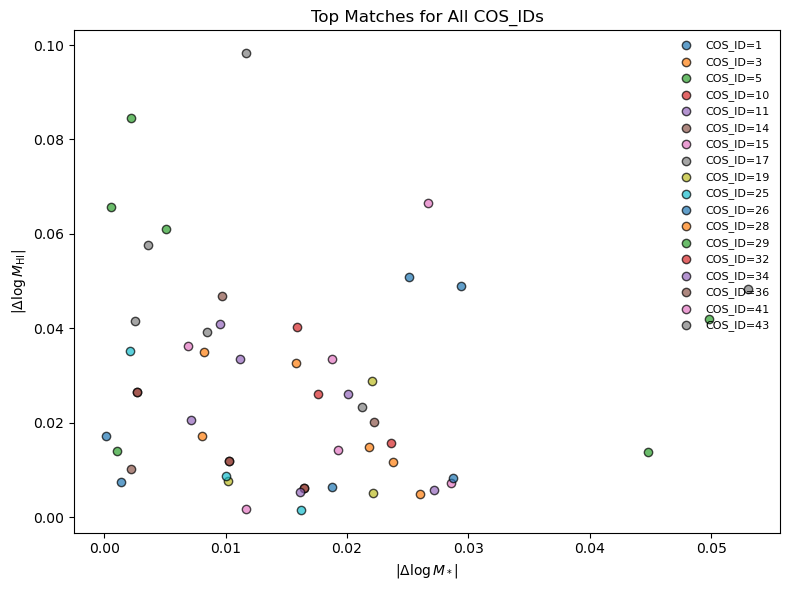

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load file with all matches
idx = pd.read_csv(OUT_CSV)

# Make a scatter plot for each COS_ID
plt.figure(figsize=(8, 6))

# Get unique COS_IDs
for cos_id in idx["COS_ID"].unique():
    sel = idx[idx["COS_ID"] == cos_id]
    plt.scatter(
        sel["dlogMstar"],
        sel["dlogMHI"],
        label=f"COS_ID={cos_id}",
        alpha=0.7,
        edgecolor='k',  # thin edge for visibility
    )

plt.xlabel(r"$|\Delta \log M_*|$")
plt.ylabel(r"$|\Delta \log M_{\rm HI}|$")
plt.title("Top Matches for All COS_IDs")
plt.legend(frameon=False, fontsize=8, loc="best")
plt.tight_layout()
plt.show()

## Downloading the face on and edge on orientation HI and stellar composite maps for the filtered galaxies

In [5]:
# ==== TNG bulk visualization downloader (CSV-driven) ====
# Reads your filtered subhalos from: COSS_GASS/COS_GASS_TNG50_matches_index.csv
# Renders HI column density + stellar JWST composites, for face-on + edge-on,
# saving PNG + HDF5 to a clean directory structure.

import os, re, time, json, pathlib
from typing import Dict, List, Optional

import pandas as pd
import requests

# -------------------------
# CONFIG
# -------------------------
API_KEY = "7f3b66fdf83ae7c85b47794073f746ff"  # consider moving to env var

SIM  = "TNG50-1"
SNAP = 99

USE_CSV  = True
CSV_PATH = "COS_GASS_TNG50_matches_index.csv"

# Common column names that might hold the TNG subhalo ID
CSV_SUBHALO_COLS = [
    "SubhaloID", "SubfindID", "subhalo_id", "Subhalo", "TNG_SubhaloID",
    "TNG50_SubhaloID", "subhalo", "subfind_id"
]
# Optional per-row overrides (only if your CSV has these columns)
CSV_SIM_COL  = None
CSV_SNAP_COL = None

OUT_ROOT = "tng_vis"
RASTER_PX = 3000
REQUEST_PAUSE_S = 0.25
ROTATIONS = ["face-on", "edge-on"]

HI_PARAMS_BASE = dict(
    partType="gas",
    partField="HI_GK",    # falls back to 'coldens_HI' if needed
    size=2.5,
    sizeType="rVirial",
    depthFac=1,
    rVirFracs="1+",
    fracsType="rVirial",
    relCoords=True,
    axesUnits="kpc",
    plotStyle="open_black",
    labelZ=True,
    labelScale=True,
    labelSim=True,
    labelHalo="mstar_mhalo",
    title=True,
    colorbars=True,
)

STELLAR_PARAMS_BASE = dict(
    partType="stars",
    partField="stellarComp-jwst_f200w-jwst_f115w-jwst_f070w",
    size=4.0,
    sizeType="rHalfMass",
    depthFac=1,
    relCoords=True,
    axesUnits="kpc",
    plotStyle="open_black",
    labelZ=True,
    labelScale=True,
    labelSim=True,
    labelHalo="mstar_mhalo",
    title=True,
    colorbars=True,
)

BASE_URL = "https://www.tng-project.org/api"
HEADERS = {"api-key": API_KEY, "Accept": "application/json,application/octet-stream,image/png"}

# -------------------------
# HELPERS
# -------------------------
def ensure_dir(path: str) -> None:
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.\-+]+", "_", str(s))

def vis_endpoint(sim: str, snap: int, subhalo_id: int, ext: str = "png") -> str:
    return f"{BASE_URL}/{sim}/snapshots/{snap}/subhalos/{subhalo_id}/vis.{ext}"

def sub_info_endpoint(sim: str, snap: int, subhalo_id: int) -> str:
    return f"{BASE_URL}/{sim}/snapshots/{snap}/subhalos/{subhalo_id}/info.json"

def fetch_json(url: str, params: Optional[Dict] = None) -> Dict:
    r = requests.get(url, headers=HEADERS, params=params, timeout=90)
    r.raise_for_status()
    return r.json()

def download_binary(url: str, params: Dict, out_path: str) -> None:
    with requests.get(url, headers=HEADERS, params=params, stream=True, timeout=600) as r:
        r.raise_for_status()
        ensure_dir(os.path.dirname(out_path))
        with open(out_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)

def render_one(sim: str, snap: int, sub_id: int,
               part_label: str, base_params: Dict,
               rotation: str, raster_px: int, out_dir: str) -> Dict[str, str]:
    params = dict(base_params)
    params["rotation"] = rotation
    params["rasterPx"] = raster_px

    size, sizeType = base_params.get("size", "NA"), base_params.get("sizeType", "NA")
    stem = f"subhalo_{sub_id}_{sanitize(part_label)}_{sanitize(rotation)}_{sanitize(sizeType)}{sanitize(size)}_rpx{raster_px}"
    png_path  = os.path.join(out_dir, f"{stem}.png")
    hdf5_path = os.path.join(out_dir, f"{stem}.hdf5")

    download_binary(vis_endpoint(sim, snap, sub_id, "png"),  params, png_path)
    time.sleep(REQUEST_PAUSE_S)
    download_binary(vis_endpoint(sim, snap, sub_id, "hdf5"), params, hdf5_path)
    time.sleep(REQUEST_PAUSE_S)
    return {"png": png_path, "hdf5": hdf5_path, "params": json.dumps(params)}

def process_one_subhalo(sim: str, snap: int, sub_id: int) -> Dict[str, Dict]:
    results = {}
    base_dir = os.path.join(OUT_ROOT, sim, f"snap{snap}", f"subhalo_{sub_id}")
    ensure_dir(base_dir)

    # info.json for traceability
    try:
        info = fetch_json(sub_info_endpoint(sim, snap, sub_id))
        info_path = os.path.join(base_dir, "info.json")
        with open(info_path, "w") as f:
            json.dump(info, f, indent=2)
        results["info_json"] = info_path
    except Exception as e:
        results["info_error"] = str(e)

    # HI (with fallback if server dislikes HI_GK)
    for rot in ROTATIONS:
        out_dir_hi = os.path.join(base_dir, "hi", sanitize(rot))
        try:
            res = render_one(sim, snap, sub_id, "HI", HI_PARAMS_BASE, rot, RASTER_PX, out_dir_hi)
            results[f"hi_{rot}"] = res
        except Exception as e:
            try_params = dict(HI_PARAMS_BASE)
            try_params["partField"] = "coldens_HI"
            try:
                res = render_one(sim, snap, sub_id, "HI_coldens", try_params, rot, RASTER_PX, out_dir_hi)
                results[f"hi_{rot}"] = res
                results[f"hi_{rot}_fallback"] = "partField=coldens_HI"
            except Exception as e2:
                results[f"hi_{rot}_error"] = f"{e}\nFallback failed: {e2}"

    # Stellar
    for rot in ROTATIONS:
        out_dir_st = os.path.join(base_dir, "stellar", sanitize(rot))
        try:
            res = render_one(sim, snap, sub_id, "stellarJWST", STELLAR_PARAMS_BASE, rot, RASTER_PX, out_dir_st)
            results[f"stellar_{rot}"] = res
        except Exception as e:
            results[f"stellar_{rot}_error"] = str(e)

    return results

def pick_first_existing_column(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def load_subhalo_ids_from_csv(csv_path: str) -> List[int]:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    df = pd.read_csv(csv_path)

    col = pick_first_existing_column(df, CSV_SUBHALO_COLS)
    if col is None:
        raise ValueError(f"Could not find any of {CSV_SUBHALO_COLS} in {csv_path}. "
                         f"Available columns: {list(df.columns)}")

    # Clean to ints, drop NaNs, unique + sorted
    ids = (
        df[col]
        .astype(str)
        .str.extract(r"(\d+)", expand=False)  # robust if column contains mixed strings
        .dropna()
        .astype(int)
        .unique()
        .tolist()
    )
    ids = sorted(ids)
    print(f"Detected subhalo column: '{col}'. Found {len(ids)} unique IDs.")
    return ids



In [6]:
idx

,COS_ID,Galaxy,MatchRank,SubhaloID,GroupID,dlogMstar,dlogMHI,dist
0,1,J0159+1346,1,618120,548,0.001419,0.007362,0.006386
1,1,J0159+1346,2,630870,637,0.000174,0.017211,0.014198
2,1,J0159+1346,3,553231,260,0.018750,0.006297,0.026644
3,3,J0852+0309,1,607530,487,0.008237,0.035000,0.031067
4,3,J0852+0309,2,579232,348,0.015784,0.032578,0.034727
5,3,J0852+0309,3,545003,236,0.026029,0.004921,0.036503
6,5,J0914+0836,1,606038,479,0.001019,0.013989,0.011625
7,5,J0914+0836,2,549091,248,0.002192,0.084553,0.069807
8,5,J0914+0836,3,622877,579,0.049780,0.042027,0.077557
9,10,J0951 + 3537,1,400974,50,0.010264,0.011894,0.017346


In [7]:
# -------------------------
# MAIN
# -------------------------
all_results = {}

subhalo_ids = load_subhalo_ids_from_csv(CSV_PATH)  # <— uses your path above
print(f"Will process {len(subhalo_ids)} subhalos.")
print(subhalo_ids)

Detected subhalo column: 'SubhaloID'. Found 50 unique IDs.
Will process 50 subhalos.
[63879, 143890, 198184, 208817, 220598, 229936, 329509, 375074, 388545, 400974, 460722, 460723, 492244, 494011, 502995, 507784, 510585, 512425, 518120, 518122, 526478, 530852, 535774, 538905, 540452, 543729, 545003, 549091, 550149, 553231, 557076, 558067, 572121, 579232, 586836, 590218, 593259, 600363, 600946, 606038, 607530, 610361, 611152, 618120, 621043, 622877, 625041, 627572, 630870, 646733]


In [8]:

for i, sub_id in enumerate(subhalo_ids, 1):
    row_sim, row_snap = SIM, SNAP
    # If you later add per-row SIM/SNAP columns, read them here similarly to:
    # if CSV_SIM_COL and CSV_SIM_COL in df.columns: ...
    print(f"[{i}/{len(subhalo_ids)}] Subhalo {sub_id} @ {row_sim} snap {row_snap}")
    try:
        all_results[str(sub_id)] = process_one_subhalo(row_sim, row_snap, sub_id)
    except Exception as e:
        all_results[str(sub_id)] = {"fatal_error": str(e)}
    time.sleep(REQUEST_PAUSE_S)

# Manifest
ensure_dir(OUT_ROOT)
manifest_path = os.path.join(OUT_ROOT, "download_manifest.json")
with open(manifest_path, "w") as f:
    json.dump(all_results, f, indent=2)

print("\nDone.")
print(f"Manifest written to: {manifest_path}")
print(f"Output root: {OUT_ROOT}")

[1/50] Subhalo 63879 @ TNG50-1 snap 99
[2/50] Subhalo 143890 @ TNG50-1 snap 99
[3/50] Subhalo 198184 @ TNG50-1 snap 99
[4/50] Subhalo 208817 @ TNG50-1 snap 99
[5/50] Subhalo 220598 @ TNG50-1 snap 99
[6/50] Subhalo 229936 @ TNG50-1 snap 99
[7/50] Subhalo 329509 @ TNG50-1 snap 99
[8/50] Subhalo 375074 @ TNG50-1 snap 99
[9/50] Subhalo 388545 @ TNG50-1 snap 99
[10/50] Subhalo 400974 @ TNG50-1 snap 99
[11/50] Subhalo 460722 @ TNG50-1 snap 99
[12/50] Subhalo 460723 @ TNG50-1 snap 99
[13/50] Subhalo 492244 @ TNG50-1 snap 99
[14/50] Subhalo 494011 @ TNG50-1 snap 99
[15/50] Subhalo 502995 @ TNG50-1 snap 99
[16/50] Subhalo 507784 @ TNG50-1 snap 99
[17/50] Subhalo 510585 @ TNG50-1 snap 99
[18/50] Subhalo 512425 @ TNG50-1 snap 99
[19/50] Subhalo 518120 @ TNG50-1 snap 99
[20/50] Subhalo 518122 @ TNG50-1 snap 99
[21/50] Subhalo 526478 @ TNG50-1 snap 99
[22/50] Subhalo 530852 @ TNG50-1 snap 99
[23/50] Subhalo 535774 @ TNG50-1 snap 99
[24/50] Subhalo 538905 @ TNG50-1 snap 99
[25/50] Subhalo 540452 @ T

In [8]:
remaining_ids = [ 630155]
# add later - 630155 , 630870,646733
 
for i, sub_id in enumerate(remaining_ids, 1):
    row_sim, row_snap = SIM, SNAP
    # If you later add per-row SIM/SNAP columns, read them here similarly to:
    # if CSV_SIM_COL and CSV_SIM_COL in df.columns: ...
    print(f"[{i}/{len(remaining_ids)}] Subhalo {sub_id} @ {row_sim} snap {row_snap}")
    try:
        all_results[str(sub_id)] = process_one_subhalo(row_sim, row_snap, sub_id)
    except Exception as e:
        all_results[str(sub_id)] = {"fatal_error": str(e)}
    time.sleep(REQUEST_PAUSE_S)



[1/1] Subhalo 630155 @ TNG50-1 snap 99


In [9]:

# Manifest
ensure_dir(OUT_ROOT)
manifest_path = os.path.join(OUT_ROOT, "download_manifest.json")
with open(manifest_path, "w") as f:
    json.dump(all_results, f, indent=2)

print("\nDone.")
print(f"Manifest written to: {manifest_path}")
print(f"Output root: {OUT_ROOT}")


Done.
Manifest written to: tng_vis/download_manifest.json
Output root: tng_vis


## Plotting all the filtered subhalos in a single plot 

In [ ]:
# ============================================
# 7-column contact sheets (FIXED for long-format CSV):
#   Col0: Obs info (name, log M*, log M_HI, matched SubhaloIDs)
#   Cols 1–6: (G1 face-on, G1 edge-on, G2 face-on, G2 edge-on, G3 face-on, G3 edge-on)
# Two figures are produced per page: HI and STELLAR.
#
# PNGs are expected at:
#   tng_vis/{SIM}/snap{SNAP}/subhalo_{ID}/{hi|stellar}/{face-on|edge-on}/*.png
# ============================================

import os, re, glob
from typing import List, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.image as mpimg
from textwrap import wrap

# ---------------- USER CONFIG ----------------

# 1) The index CSV you showed (long format: 3 rows per obs galaxy)
OBS_MATCHES_CSV = "/home/tnguser/COSS_GASS/COS_GASS_TNG50_matches_index.csv"

# 2) The observed parameters table (to get log10 M* and log10 M_HI)
OBS_PARAMS_TXT = "/home/tnguser/COSS_GASS/COS_GASS_parameters.txt"

# 3) Where the downloaded PNGs live (from your image downloader)
OUT_ROOT = "tng_vis"

# 4) Simulation/snapshot used for the saved images
SIM  = "TNG50-1"
SNAP = 99

# 5) Output directory for the assembled big figures
OUT_FIGS = "tng_contact_sheets_7col"

# 6) File name base for outputs (no extension)
OUT_BASENAME = "COS_GASS_TNG50_matches"

# High-DPI (zoom-friendly)
DPI = 350

# Layout sizing
ROW_HEIGHT_INCH  = 2.2     # height per row; overall fig height = rows * this
INFO_COL_WIDTH   = 3.8     # width (inches) of the 0th info column
IMG_COL_WIDTH    = 2.4     # width (inches) of each image column
TITLE_FONTSIZE   = 12
INFO_TITLE_SIZE  = 16
INFO_TEXT_SIZE   = 11

# Optional pagination to keep file sizes reasonable (None = one giant page)
MAX_ROWS_PER_PAGE = None   # e.g., 25 to split into pages of 25 rows

# ---------------- HELPERS ----------------

def sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.\-+]+", "_", str(s))

def find_png(sim: str, snap: int, sub_id: int, modality: str, rotation: str) -> Optional[str]:
    """
    modality: "hi" or "stellar"
    rotation: "face-on" or "edge-on"
    Returns a PNG path if found, else None.
    """
    base = os.path.join(OUT_ROOT, sim, f"snap{snap}", f"subhalo_{sub_id}", modality, rotation)
    if not os.path.isdir(base):
        return None
    candidates = sorted(glob.glob(os.path.join(base, "*.png")))
    if not candidates:
        return None

    # Prefer consistent filename stems if multiple exist
    if modality == "hi":
        pref = [p for p in candidates if "HI" in os.path.basename(p)]
        if pref:
            return pref[0]
    if modality == "stellar":
        pref = [p for p in candidates if "stellarJWST" in os.path.basename(p)]
        if pref:
            return pref[0]
    return candidates[0]

def draw_info_panel(ax, name: str, mstar, mhi, matched_ids: List[Optional[int]]) -> None:
    ax.axis("off")
    if pd.isna(name) or name is None or str(name).strip() == "":
        name = "—"

    # Big, centered name
    ax.text(0.5, 0.82, "\n".join(wrap(str(name), width=28)),
            ha="center", va="center", fontsize=INFO_TITLE_SIZE, fontweight="bold")

    mstar_str = "—" if (mstar is None or pd.isna(mstar)) else f"{mstar}"
    mhi_str   = "—" if (mhi   is None or pd.isna(mhi))   else f"{mhi}"

    lines = [
        rf"$\log M_* = {mstar_str}$",
        rf"$\log M_{{\mathrm{{HI}}}} = {mhi_str}$",
        "",
        "Matches:",
        f"G1 SubhaloID = {matched_ids[0] if matched_ids[0] is not None else '—'}",
        f"G2 SubhaloID = {matched_ids[1] if matched_ids[1] is not None else '—'}",
        f"G3 SubhaloID = {matched_ids[2] if matched_ids[2] is not None else '—'}",
    ]
    ax.text(0.5, 0.28, "\n".join(lines), ha="center", va="center", fontsize=INFO_TEXT_SIZE)

def draw_image(ax, path: Optional[str], title: str) -> None:
    ax.axis("off")
    if path is None or not os.path.exists(path):
        ax.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=11, color="crimson")
        ax.set_title(title, fontsize=TITLE_FONTSIZE)
        return
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)

def build_contact_sheet_7col(df_obs: pd.DataFrame,
                             modality: str,
                             name_col: str,
                             mstar_col: Optional[str],
                             mhi_col: Optional[str],
                             sub_cols: List[str],
                             out_basename: str,
                             dpi: int = 300) -> List[str]:
    """
    modality: "hi" or "stellar"
    sub_cols: [col_for_G1, col_for_G2, col_for_G3]  (must be 3 columns)
    Returns list of saved page paths (PNG+PDF).
    """
    assert modality in ("hi", "stellar")
    assert len(sub_cols) == 3, "Need exactly 3 subhalo ID columns for the three choices."

    rows_total = len(df_obs)
    if rows_total == 0:
        raise ValueError("No rows in observation table (after pivot/merge).")

    # Pagination
    if MAX_ROWS_PER_PAGE is None:
        pages = [(0, rows_total)]
    else:
        pages, start = [], 0
        while start < rows_total:
            end = min(start + MAX_ROWS_PER_PAGE, rows_total)
            pages.append((start, end))
            start = end

    # Figure width = info col + 6 image cols
    fig_w = INFO_COL_WIDTH + 6 * IMG_COL_WIDTH
    saved = []

    for (start, end) in pages:
        nrows = end - start
        fig_h = max(1.0, nrows * ROW_HEIGHT_INCH)

        fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
        # Grid: nrows x 7
        gs = gridspec.GridSpec(
            nrows=nrows, ncols=7, figure=fig,
            width_ratios=[INFO_COL_WIDTH] + [IMG_COL_WIDTH]*6,
            wspace=0.05, hspace=0.12
        )

        # Fill each row
        for i, (_, row) in enumerate(df_obs.iloc[start:end].iterrows()):
            name  = row[name_col] if name_col in row.index else None
            mstar = row[mstar_col] if (mstar_col and mstar_col in row.index) else None
            mhi   = row[mhi_col]   if (mhi_col   and mhi_col   in row.index) else None

            # Extract three SubhaloIDs (may be missing)
            ids = []
            for c in sub_cols:
                v = row[c] if c in row.index else None
                if v is None or (isinstance(v, float) and pd.isna(v)) or str(v).strip() == "":
                    ids.append(None)
                else:
                    # robust cast to int if string-like
                    try:
                        v2 = int(re.findall(r"\d+", str(v))[0])
                    except Exception:
                        v2 = None
                    ids.append(v2)

            # Info column (col 0)
            ax_info = fig.add_subplot(gs[i, 0])
            draw_info_panel(ax_info, name, mstar, mhi, ids)

            # Image columns (six): G1 F, G1 E, G2 F, G2 E, G3 F, G3 E
            layout = [
                ("G1 — face-on",  ids[0], "face-on"),
                ("G1 — edge-on",  ids[0], "edge-on"),
                ("G2 — face-on",  ids[1], "face-on"),
                ("G2 — edge-on",  ids[1], "edge-on"),
                ("G3 — face-on",  ids[2], "face-on"),
                ("G3 — edge-on",  ids[2], "edge-on"),
            ]
            for j, (label, sid, rot) in enumerate(layout, start=1):
                ax = fig.add_subplot(gs[i, j])
                img_path = None if sid is None else find_png(SIM, SNAP, sid, modality, rot)
                draw_image(ax, img_path, f"{label}")

        # Big figure title
        fig.suptitle(f"{SIM} snap {SNAP} — {modality.upper()} | Obs–Sim 7-column contact sheet",
                     fontsize=16, y=0.995)

        # Save outputs
        os.makedirs(OUT_FIGS, exist_ok=True)
        page_tag = "" if MAX_ROWS_PER_PAGE is None else f"_rows{start+1}-{end}"
        out_base = f"{sanitize(out_basename)}_{modality}{page_tag}"
        out_png  = os.path.join(OUT_FIGS, f"{out_base}.png")
        out_pdf  = os.path.join(OUT_FIGS, f"{out_base}.pdf")
        fig.savefig(out_png, dpi=dpi, bbox_inches="tight")
        fig.savefig(out_pdf, dpi=dpi, bbox_inches="tight")
        plt.close(fig)
        saved.extend([out_png, out_pdf])
        print(f"Saved: {out_png} ({dpi} dpi)")
        print(f"Saved: {out_pdf}")

    return saved

# ---------------- LOAD + PIVOT + MERGE ----------------

# 1) Load the long-format match index (3 rows per observed galaxy)
matches = pd.read_csv(OBS_MATCHES_CSV)

# Robust types
matches["MatchRank"] = pd.to_numeric(matches["MatchRank"], errors="coerce").astype("Int64")
matches["SubhaloID"] = pd.to_numeric(matches["SubhaloID"], errors="coerce").astype("Int64")

# 2) Pivot to wide format: one row per (COS_ID, Galaxy), columns: SubhaloID_1..3
wide = (
    matches
    .pivot_table(index=["COS_ID", "Galaxy"], columns="MatchRank", values="SubhaloID", aggfunc="first")
    .reset_index()
    .rename(columns={1: "SubhaloID_1", 2: "SubhaloID_2", 3: "SubhaloID_3"})
)

# 3) Bring in observed M_star and M_HI from the original parameters file
#    (columns are log10(M/Msun); '-' means missing)
obs_params = pd.read_csv(OBS_PARAMS_TXT, sep=",", engine="python")
obs_params.columns = [c.strip().replace(" ", "_") for c in obs_params.columns]
# normalize types and '-' to NaN
obs_params = obs_params.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)
for c in ["M_star", "M_HI"]:
    if c in obs_params.columns:
        obs_params[c] = pd.to_numeric(obs_params[c], errors="coerce")

# Merge on both keys (safe if names may repeat)
merged = pd.merge(
    wide,
    obs_params[["COS_ID", "Galaxy", "M_star", "M_HI"]],
    on=["COS_ID", "Galaxy"],
    how="left"
)

# Build a nicer label if you want (e.g., "COS_ID: Galaxy")
merged["Label"] = merged.apply(lambda r: f"{int(r['COS_ID'])}: {r['Galaxy']}", axis=1)

print("Wide table ready:")
print(merged.head(6)[["COS_ID","Galaxy","SubhaloID_1","SubhaloID_2","SubhaloID_3","M_star","M_HI","Label"]])

# Keep only rows that have at least one matched SubhaloID present
mask_any = merged[["SubhaloID_1", "SubhaloID_2", "SubhaloID_3"]].notna().any(axis=1)
obs_clean = merged.loc[mask_any].reset_index(drop=True)
print(f"Rows with >=1 match ID: {len(obs_clean)} / {len(merged)}")

# ---------------- BUILD TWO FIGURES (HI & STELLAR) ----------------

saved_hi = build_contact_sheet_7col(
    df_obs=obs_clean,
    modality="hi",
    name_col="Label",       # or "Galaxy" if you prefer just the name
    mstar_col="M_star",
    mhi_col="M_HI",
    sub_cols=["SubhaloID_1", "SubhaloID_2", "SubhaloID_3"],
    out_basename=f"{OUT_BASENAME}",
    dpi=DPI,
)

saved_st = build_contact_sheet_7col(
    df_obs=obs_clean,
    modality="stellar",
    name_col="Label",       # or "Galaxy"
    mstar_col="M_star",
    mhi_col="M_HI",
    sub_cols=["SubhaloID_1", "SubhaloID_2", "SubhaloID_3"],
    out_basename=f"{OUT_BASENAME}",
    dpi=DPI,
)

print("\nAll done. Outputs:")
for p in saved_hi + saved_st:
    print("  " + p)

/tmp/ipykernel_674/1225371410.py:242: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs_params = obs_params.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)


Wide table ready:
   COS_ID        Galaxy  SubhaloID_1  SubhaloID_2  SubhaloID_3  M_star  M_HI  \
0       1    J0159+1346       618120       630870       553231    10.1   9.4   
1       3    J0852+0309       607530       579232       545003    10.3   9.7   
2       5    J0914+0836       606038       549091       622877    10.0   9.0   
3      10  J0951 + 3537       400974       507784       540452    10.6   9.9   
4      11    J0958+3204       543729       535774       229936    10.7  10.0   
5      14  J1032 + 2112       400974       507784       540452    10.6   9.9   

              Label  
0     1: J0159+1346  
1     3: J0852+0309  
2     5: J0914+0836  
3  10: J0951 + 3537  
4    11: J0958+3204  
5  14: J1032 + 2112  
Rows with >=1 match ID: 18 / 18


## Less RAM heavy version of the plotting code

In [1]:
# ============================================================
# Memory-efficient 7-column contact sheets using PIL (fixed fonts)
#   Col0: Obs info (name, log M*, log M_HI, matched SubhaloIDs)
#   Cols 1–6: (G1 face-on, G1 edge-on, G2 face-on, G2 edge-on, G3 face-on, G3 edge-on)
#
# Inputs:
#   - Long-form matches CSV: 3 rows per obs galaxy (MatchRank=1/2/3)
#   - Observed params TXT: log10 M*, log10 M_HI, names
#   - PNGs at: tng_vis/{SIM}/snap{SNAP}/subhalo_{ID}/{hi|stellar}/{face-on|edge-on}/*.png
#
# RAM-saving choices:
#   • PIL (no giant Matplotlib figures)
#   • Pagination (ROWS_PER_PAGE)
#   • Downscale each image before paste
#   • Save each page immediately; GC in between
# ============================================================

import os, re, glob, gc
from textwrap import wrap
from typing import List, Optional

import numpy as np
import pandas as pd

from PIL import Image, ImageDraw, ImageFont

# ---------------- USER CONFIG ----------------

OBS_MATCHES_CSV = "/home/tnguser/COSS_GASS/COS_GASS_TNG50_matches_index.csv"  # long format
OBS_PARAMS_TXT  = "/home/tnguser/COSS_GASS/COS_GASS_parameters.txt"

OUT_ROOT  = "tng_vis"      # where the PNGs live
SIM       = "TNG50-1"
SNAP      = 99

OUT_FIGS      = "tng_contact_sheets_7col"        # output dir
OUT_BASENAME  = "COS_GASS_TNG50_matches"         # base name for files

# Keep these modest for RAM safety:
DPI               = 200     # 150–200 is plenty; higher => more RAM
ROWS_PER_PAGE     = 12      # <= 12 keeps each page reasonable
BACKGROUND_COLOR  = (255, 255, 255)  # white
TEXT_COLOR        = (10, 10, 10)     # near black
MISSING_COLOR     = (180, 20, 30)    # "image not found" text

# Layout (inches convert to pixels via DPI)
ROW_HEIGHT_INCH   = 2.0
INFO_COL_WIDTH    = 3.2
IMG_COL_WIDTH     = 2.0
TITLE_FONT_SIZE   = 18
INFO_TEXT_SIZE    = 13
TILE_TITLE_SIZE   = 12   # per-tile label (e.g., "G1 — face-on")
TILE_TITLE_HEIGHT = 18   # pixels reserved above image slot for the label

# ---------------- UTILITIES ----------------

def sanitize(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_.\-+]+", "_", str(s))

def px(inches: float) -> int:
    return int(round(inches * DPI))

def load_font(size: int) -> ImageFont.ImageFont:
    """
    Try a few common TTFs; fall back to PIL's default bitmap font.
    We avoid using .size anywhere; we always measure with draw.textbbox.
    """
    candidates = [
        "DejaVuSans.ttf",                      # shipped with many Pillow installs
        "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
        "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
        "/Library/Fonts/Arial.ttf",
        "Arial.ttf",
    ]
    for path in candidates:
        try:
            return ImageFont.truetype(path, size=size)
        except Exception:
            pass
    # Fallback: default (bitmap) font
    return ImageFont.load_default()

def find_png(sim: str, snap: int, sub_id: int, modality: str, rotation: str) -> Optional[str]:
    base = os.path.join(OUT_ROOT, sim, f"snap{snap}", f"subhalo_{sub_id}", modality, rotation)
    if not os.path.isdir(base):
        return None
    candidates = sorted(glob.glob(os.path.join(base, "*.png")))
    if not candidates:
        return None
    if modality == "hi":
        pref = [p for p in candidates if "HI" in os.path.basename(p)]
        if pref: return pref[0]
    if modality == "stellar":
        pref = [p for p in candidates if "stellarJWST" in os.path.basename(p)]
        if pref: return pref[0]
    return candidates[0]

def wrap_text(draw: ImageDraw.ImageDraw, text: str, font: ImageFont.ImageFont, max_width_px: int) -> str:
    """Greedy wrap using actual text measurement; keeps lines within max_width_px."""
    words = (text or "").split()
    if not words: 
        return ""
    lines, cur = [], words[0]
    for w in words[1:]:
        test = cur + " " + w
        if draw.textlength(test, font=font) <= max_width_px:
            cur = test
        else:
            lines.append(cur)
            cur = w
    lines.append(cur)
    return "\n".join(lines)

def text_block_size(draw: ImageDraw.ImageDraw, text: str, font: ImageFont.ImageFont, line_spacing_px: int = 2):
    """Measure multi-line text block via draw.textbbox per line."""
    lines = (text or "").split("\n")
    widths, heights = [], []
    for ln in lines:
        # textbbox returns (x0,y0,x1,y1); height = y1-y0
        bbox = draw.textbbox((0,0), ln, font=font)
        widths.append(bbox[2] - bbox[0])
        heights.append(bbox[3] - bbox[1])
    block_w = max(widths) if widths else 0
    block_h = sum(heights) + line_spacing_px * max(0, len(lines)-1)
    return block_w, block_h, heights

def draw_centered_text(draw, box, text, font, fill=TEXT_COLOR, valign="center", line_spacing_px: int = 2):
    """
    Draw multi-line text centered horizontally in a box (x0,y0,x1,y1),
    and vertically aligned by 'valign' using measured bbox per line.
    """
    x0, y0, x1, y1 = box
    w = x1 - x0
    lines = (text or "").split("\n")
    # Measure block
    block_w, block_h, heights = text_block_size(draw, text, font, line_spacing_px)
    if valign == "top":
        y_start = y0
    elif valign == "bottom":
        y_start = y1 - block_h
    else:
        y_start = y0 + (y1 - y0 - block_h) // 2
    # Draw each line
    y = y_start
    for i, ln in enumerate(lines):
        ln_w = draw.textlength(ln, font=font)
        x = x0 + (w - ln_w) // 2
        draw.text((x, y), ln, font=font, fill=fill)
        y += heights[i] + line_spacing_px

def paste_image_centered(page_img, img_path, slot_box, label, fonts):
    """Paste (downscaled) image centered in slot_box; draw label above it."""
    draw = ImageDraw.Draw(page_img)
    # Draw label at top of slot
    x0, y0, x1, y1 = slot_box
    label_box = (x0, y0, x1, y0 + TILE_TITLE_HEIGHT)
    draw_centered_text(draw, label_box, label, fonts["tile"], fill=TEXT_COLOR, valign="center")

    # Image area (below label)
    img_box = (x0, y0 + TILE_TITLE_HEIGHT, x1, y1)
    if (img_path is None) or (not os.path.exists(img_path)):
        draw_centered_text(draw, img_box, "Image not found", fonts["tile"], fill=MISSING_COLOR)
        return

    try:
        with Image.open(img_path) as im:
            im = im.convert("RGB")
            # Fit to img_box maintaining aspect ratio
            slot_w = img_box[2] - img_box[0]
            slot_h = img_box[3] - img_box[1]
            im.thumbnail((slot_w, slot_h), Image.Resampling.LANCZOS)
            # center paste
            off_x = img_box[0] + (slot_w - im.width)//2
            off_y = img_box[1] + (slot_h - im.height)//2
            page_img.paste(im, (off_x, off_y))
    except Exception:
        draw_centered_text(draw, img_box, "Error loading image", fonts["tile"], fill=MISSING_COLOR)

def build_pages_pil(df_obs: pd.DataFrame,
                    modality: str,
                    name_col: str,
                    mstar_col: Optional[str],
                    mhi_col: Optional[str],
                    sub_cols: List[str],
                    out_basename: str):
    """
    Memory-efficient page builder using PIL. Saves each page immediately.
    Returns list of file paths (png/pdf) printed to stdout.
    """
    assert modality in ("hi", "stellar")
    assert len(sub_cols) == 3
    os.makedirs(OUT_FIGS, exist_ok=True)

    # Page geometry in pixels
    page_w = px(INFO_COL_WIDTH + 6*IMG_COL_WIDTH)
    row_h  = px(ROW_HEIGHT_INCH)

    # Column x coordinates
    x = [0]
    x.append(px(INFO_COL_WIDTH))                     # after info col
    for _ in range(6):                               # six image columns
        x.append(x[-1] + px(IMG_COL_WIDTH))         # x has 8 entries: slot j is (x[j], x[j+1])

    # Fonts (robust load)
    font_title = load_font(TITLE_FONT_SIZE)
    font_info  = load_font(INFO_TEXT_SIZE)
    font_tile  = load_font(TILE_TITLE_SIZE)
    fonts = {"title": font_title, "info": font_info, "tile": font_tile}

    total_rows = len(df_obs)
    pages = list(range(0, total_rows, ROWS_PER_PAGE))

    for pstart in pages:
        pend = min(pstart + ROWS_PER_PAGE, total_rows)
        nrows = pend - pstart
        page_h = row_h * nrows

        # Create blank page
        page = Image.new("RGB", (page_w, page_h), BACKGROUND_COLOR)
        draw = ImageDraw.Draw(page)

        # Fill each row
        for i in range(nrows):
            row = df_obs.iloc[pstart + i]
            y0, y1 = i*row_h, (i+1)*row_h

            # Info panel (col 0)
            name  = str(row.get(name_col, "") or "—")
            mstar = row.get(mstar_col, np.nan)
            mhi   = row.get(mhi_col,   np.nan)

            info_box = (x[0], y0, x[1], y1)
            # Title (wrapped)
            title_wrapped = wrap_text(draw, name, fonts["title"], max_width_px=(x[1]-x[0]-10))
            # Draw title at top of info box
            title_height = TILE_TITLE_HEIGHT + 6  # a little more room for big titles
            title_box = (x[0]+6, y0+6, x[1]-6, y0 + title_height + 6)
            draw_centered_text(draw, title_box, title_wrapped, fonts["title"], fill=TEXT_COLOR, valign="center")

            # Info text lower
            mstar_str = "—" if (mstar is None or pd.isna(mstar)) else f"{mstar}"
            mhi_str   = "—" if (mhi   is None or pd.isna(mhi))   else f"{mhi}"
            ids = []
            for c in sub_cols:
                v = row.get(c, None)
                try:
                    v2 = int(v) if pd.notna(v) else None
                except Exception:
                    v2 = None
                ids.append(v2)

            info_lines = [
                f"log M_*  = {mstar_str}",
                f"log M_HI = {mhi_str}",
                "",
                f"G1 SubhaloID = {ids[0] if ids[0] is not None else '—'}",
                f"G2 SubhaloID = {ids[1] if ids[1] is not None else '—'}",
                f"G3 SubhaloID = {ids[2] if ids[2] is not None else '—'}",
            ]
            info_txt = "\n".join(info_lines)
            lower_box = (x[0]+8, y0 + title_height + 12, x[1]-8, y1-8)
            draw_centered_text(draw, lower_box, info_txt, fonts["info"], fill=TEXT_COLOR, valign="top")

            # Six image tiles
            layout = [
                ("G1 — face-on",  ids[0], "face-on", 1),
                ("G1 — edge-on",  ids[0], "edge-on", 2),
                ("G2 — face-on",  ids[1], "face-on", 3),
                ("G2 — edge-on",  ids[1], "edge-on", 4),
                ("G3 — face-on",  ids[2], "face-on", 5),
                ("G3 — edge-on",  ids[2], "edge-on", 6),
            ]
            for label, sid, rot, col_idx in layout:
                slot = (x[col_idx], y0, x[col_idx+1], y1)
                img_path = None if sid is None else find_png(SIM, SNAP, sid, modality, rot)
                paste_image_centered(page, img_path, slot, label, fonts)

        # Save page (PNG + PDF)
        os.makedirs(OUT_FIGS, exist_ok=True)
        page_tag = f"_rows{pstart+1}-{pend}" if len(pages) > 1 else ""
        out_base = f"{sanitize(out_basename)}_{modality}{page_tag}"
        out_png  = os.path.join(OUT_FIGS, f"{out_base}.png")
        out_pdf  = os.path.join(OUT_FIGS, f"{out_base}.pdf")

        page.save(out_png, format="PNG")
        try:
            page.save(out_pdf, format="PDF")  # 1-page PDF; OK if your Pillow build supports PDF
        except Exception:
            pass

        print(f"Saved: {out_png}")
        if os.path.exists(out_pdf):
            print(f"Saved: {out_pdf}")

        # Free memory aggressively before next page
        del page, draw
        gc.collect()

# ---------------- LOAD + PIVOT + MERGE (tiny memory) ----------------

# 1) Long-form matches (three rows per COS_ID)
matches = pd.read_csv(OBS_MATCHES_CSV)
matches["MatchRank"] = pd.to_numeric(matches["MatchRank"], errors="coerce").astype("Int64")
matches["SubhaloID"] = pd.to_numeric(matches["SubhaloID"], errors="coerce").astype("Int64")

# 2) Pivot to wide: one row per (COS_ID, Galaxy) with SubhaloID_1..3
wide = (
    matches
    .pivot_table(index=["COS_ID", "Galaxy"], columns="MatchRank", values="SubhaloID", aggfunc="first")
    .reset_index()
    .rename(columns={1: "SubhaloID_1", 2: "SubhaloID_2", 3: "SubhaloID_3"})
)

# 3) Observed parameters (bring M_star, M_HI)
obs_params = pd.read_csv(OBS_PARAMS_TXT, sep=",", engine="python")
obs_params.columns = [c.strip().replace(" ", "_") for c in obs_params.columns]
obs_params = obs_params.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)
for c in ["M_star", "M_HI"]:
    if c in obs_params.columns:
        obs_params[c] = pd.to_numeric(obs_params[c], errors="coerce")

merged = pd.merge(
    wide,
    obs_params[["COS_ID", "Galaxy", "M_star", "M_HI"]],
    on=["COS_ID", "Galaxy"],
    how="left"
)

# Keep only rows having at least one match
mask_any = merged[["SubhaloID_1","SubhaloID_2","SubhaloID_3"]].notna().any(axis=1)
obs_clean = merged.loc[mask_any].reset_index(drop=True)

# Compact label
obs_clean["Label"] = obs_clean.apply(lambda r: f"{int(r['COS_ID'])}: {r['Galaxy']}", axis=1)

print(f"Total galaxies to render: {len(obs_clean)}")
print(obs_clean.head(3))

# ---------------- RENDER PAGES (HI then STELLAR) ----------------

build_pages_pil(
    df_obs=obs_clean,
    modality="hi",
    name_col="Label",
    mstar_col="M_star",
    mhi_col="M_HI",
    sub_cols=["SubhaloID_1","SubhaloID_2","SubhaloID_3"],
    out_basename=OUT_BASENAME
)

build_pages_pil(
    df_obs=obs_clean,
    modality="stellar",
    name_col="Label",
    mstar_col="M_star",
    mhi_col="M_HI",
    sub_cols=["SubhaloID_1","SubhaloID_2","SubhaloID_3"],
    out_basename=OUT_BASENAME
)

print("Done.")

/tmp/ipykernel_761/2202171764.py:317: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  obs_params = obs_params.applymap(lambda x: np.nan if (isinstance(x, str) and x.strip() == "-") else x)


Total galaxies to render: 18
   COS_ID      Galaxy  SubhaloID_1  SubhaloID_2  SubhaloID_3  M_star  M_HI  \
0       1  J0159+1346       618120       630870       553231    10.1   9.4   
1       3  J0852+0309       607530       579232       545003    10.3   9.7   
2       5  J0914+0836       606038       549091       622877    10.0   9.0   

           Label  
0  1: J0159+1346  
1  3: J0852+0309  
2  5: J0914+0836  
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_hi_rows1-12.png
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_hi_rows1-12.pdf
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_hi_rows13-18.png
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_hi_rows13-18.pdf
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_stellar_rows1-12.png
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_stellar_rows1-12.pdf
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_stellar_rows13-18.png
Saved: tng_contact_sheets_7col/COS_GASS_TNG50_matches_stellar_rows13-18.pd

## Converting the folders into zip/tarball and downloading

In [2]:
ARCHIVE = "/home/tnguser/COSS_GASS/COS_GASS_artifacts.tar.gz"


In [3]:
# Make a tar.gz of both folders (quietly). 
# If these dirs live elsewhere, replace the paths below.
!tar -czf "{ARCHIVE}" -C "/home/tnguser/COSS_GASS" tng_vis tng_contact_sheets_7col

# Show a clickable download link inside Jupyter
from IPython.display import FileLink, display
display(FileLink(ARCHIVE, result_html_prefix="Download: "))

/home/tnguser/COSS_GASS/COS_GASS_artifacts.tar.gz